# Learning to optimize parametric nonlinear programming problem (pNLP) using Neuromancer


This is an interactive notebook based on the python script [Part_1_LearnToOptimize_tutorial.py](./Part_1_LearnToOptimize_tutorial.py).  
We demonstrate how the NeuroMANCER toolbox can be used to solve parametric constrained [Rosenbrock problem](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$
\begin{align}
&\text{minimize } &&  (1-x)^2 + a(y-x^2)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

with parameters $p, a$ and decision variables $x, y$.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [1]:
!pip install --upgrade matplotlib

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


In [4]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

  Using cached setuptools-61.0.0-py3-none-any.whl (1.1 MB)
  Using cached casadi-3.6.3-cp39-none-win_amd64.whl (39.7 MB)
  Using cached mlflow-2.3.2-py3-none-any.whl (17.7 MB)
  Using cached plum_dispatch-2.0.1-py3-none-any.whl (27 kB)
  Using cached pyarrow-11.0.0-cp39-cp39-win_amd64.whl (20.6 MB)
  Using cached alembic-1.11.1-py3-none-any.whl (224 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached waitress-2.1.2-py3-none-any.whl (57 kB)
  Using cached databricks_cli-0.17.7-py3-none-any.whl
  Using cached sqlparse-0.4.4-py3-none-any.whl (41 kB)
  Using cached docker-6.1.2-py3-none-any.whl (148 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached beartype-0.14.0-py3-none-any.whl (720 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Using cached pywin32-306-cp39-cp39-win_amd64.whl (9.3 MB)
  Using cached gitdb

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to c:\users\drgo694\appdata\local\temp\pip-req-build-fhgtva59
  Resolved https://github.com/pnnl/neuromancer.git to commit ac646b36df18fe192f2a4ec2c88f1995c9ad759a
  Created wheel for neuromancer: filename=neuromancer-1.3.1-py3-none-any.whl size=96253 sha256=517749b59e623dab94b7bb1afa416272f98044b04c4440b0e3656987ac9a2ed6
  Stored in directory: C:\Users\drgo694\AppData\Local\Temp\pip-ephem-wheel-cache-xm7vts_0\wheels\cf\58\0e\fa96fde974dfb3196e8a260d0b557130bfa1defffda27af33f
Successfully built neuromancer


  Running command git clone -q https://github.com/pnnl/neuromancer.git 'C:\Users\drgo694\AppData\Local\Temp\pip-req-build-fhgtva59'


### Import

In [1]:
import torch
import torch.nn as nn
import numpy as np
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from casadi import *
import casadi

C:\Users\drgo694\Anaconda3\envs\neuromancer\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Dataset

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [4]:
nsim = 5000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
a_low, a_high, p_low, p_high = 0.2, 1.2, 0.5, 2.0
samples_train = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
                 "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
               "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"a": torch.FloatTensor(nsim, 1).uniform_(a_low, a_high),
               "p": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

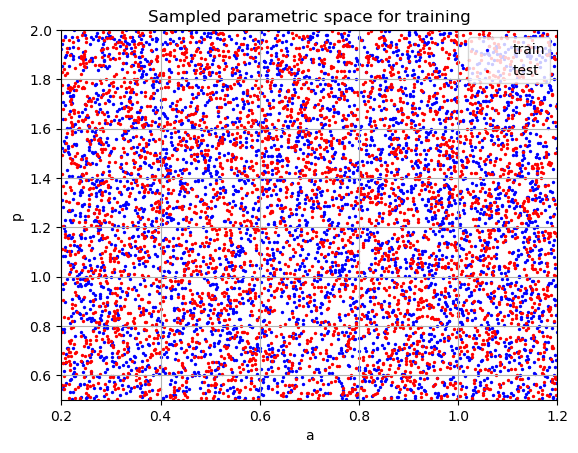

In [5]:
# visualize taining and test samples for 2D parametric space
a_train = samples_train['a'].numpy()
p_train = samples_train['p'].numpy()
a_dev = samples_dev['a'].numpy()
p_dev = samples_dev['p'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(a_low, a_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('a')
plt.ylabel('p')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

# pNLP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [6]:
# wrap pytorch callable concatenating problem parameters/features (a, p)
# into symbolic representation via the Node class:
# features(a, p) -> xi
xi = lambda a, p: torch.cat([a, p], dim=-1)
features = Node(xi, ['a', 'p'], ['xi'], name='features')
# define neural architecture for the trainable solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class:
# sol_map(xi) -> x
sol_map = Node(func, ['xi'], ['x'], name='map')

## Objective and Constraints in NeuroMANCER

In [7]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# define decision variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# problem parameters sampled in the dataset
p = variable('p')
a = variable('a')

# objective function
f = (1-x)**2 + a*(y-x**2)**2
obj = f.minimize(weight=1.0, name='obj')

# constraints
Q_con = 100.  # constraint penalty weights
con_1 = Q_con*(x >= y)
con_2 = Q_con*((p/2)**2 <= x**2+y**2)
con_3 = Q_con*(x**2+y**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

In [8]:
# constrained optimization problem construction
objectives = [obj]
constraints = [con_1, con_2, con_3]
components = [features, sol_map]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [9]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [10]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [11]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 6.46101713180542
epoch: 1  train_loss: 0.14166869223117828
epoch: 2  train_loss: 0.122811459004879
epoch: 3  train_loss: 0.09354948252439499
epoch: 4  train_loss: 0.08213940262794495
epoch: 5  train_loss: 0.07559637725353241
epoch: 6  train_loss: 0.06996264308691025
epoch: 7  train_loss: 0.07524508237838745
epoch: 8  train_loss: 0.06995179504156113
epoch: 9  train_loss: 0.07558181881904602
epoch: 10  train_loss: 0.08685539662837982
epoch: 11  train_loss: 0.08737140148878098
epoch: 12  train_loss: 0.09502537548542023
epoch: 13  train_loss: 0.09515944123268127
epoch: 14  train_loss: 0.06473420560359955
epoch: 15  train_loss: 0.07183793187141418
epoch: 16  train_loss: 0.07010874897241592
epoch: 17  train_loss: 0.08434858918190002
epoch: 18  train_loss: 0.0720629021525383
epoch: 19  train_loss: 0.06483248621225357
epoch: 20  train_loss: 0.10517900437116623
epoch: 21  train_loss: 0.09720668941736221
epoch: 22  train_loss: 0.07514192909002304
epoch: 23  train_loss: 0.06

epoch: 189  train_loss: 0.07494067400693893
epoch: 190  train_loss: 0.06731397658586502
epoch: 191  train_loss: 0.054497335106134415
epoch: 192  train_loss: 0.06009292975068092
epoch: 193  train_loss: 0.0796268954873085
epoch: 194  train_loss: 0.05780944228172302
epoch: 195  train_loss: 0.055329639464616776
epoch: 196  train_loss: 0.05639529600739479
epoch: 197  train_loss: 0.07316097617149353
epoch: 198  train_loss: 0.0581083819270134
epoch: 199  train_loss: 0.05508158728480339
epoch: 200  train_loss: 0.07188249379396439
epoch: 201  train_loss: 0.06423478573560715
epoch: 202  train_loss: 0.05723390355706215
epoch: 203  train_loss: 0.059025924652814865
epoch: 204  train_loss: 0.057219769805669785
epoch: 205  train_loss: 0.05583607405424118
epoch: 206  train_loss: 0.06446698307991028
epoch: 207  train_loss: 0.06111026555299759
epoch: 208  train_loss: 0.05870216339826584
epoch: 209  train_loss: 0.0659882128238678
epoch: 210  train_loss: 0.05490638315677643
epoch: 211  train_loss: 0.06174

<All keys matched successfully>

## Get pNLP solution from trained neural network

In [12]:
# selected problem parameters
p = 1.0
a = 1.0

In [13]:
# Solution to mpNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

0.7393329
0.5048104


## Get pNLP solution from CasADi as a benchmark

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

In [14]:
# instantiate casadi optimizaiton problem class
def NLP_param(a, p, opti_silent=False):
    opti = casadi.Opti()
    # define variables
    x = opti.variable()
    y = opti.variable()
    p_opti = opti.parameter()
    a_opti = opti.parameter()
    # define objective and constraints
    opti.minimize((1 - x) ** 2 + a_opti * (y - x ** 2) ** 2)
    opti.subject_to(x >= y)
    opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
    opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
    # select IPOPT solver and solve the NLP
    if opti_silent:
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    else:
        opts = {}
    opti.solver('ipopt', opts)
    # set parametric values
    opti.set_value(p_opti, p)
    opti.set_value(a_opti, a)
    return opti, x, y

# construct casadi problem
opti, x, y = NLP_param(a, p)
# solve NLP via casadi
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

In [15]:
print(f"x = {sol.value(x)}")
print(f"y = {sol.value(y)}")

x = 0.8081695826847699
y = 0.588949838491767


## Compare: NeuroMANCER vs. CasADi

0.7393329
0.5048104


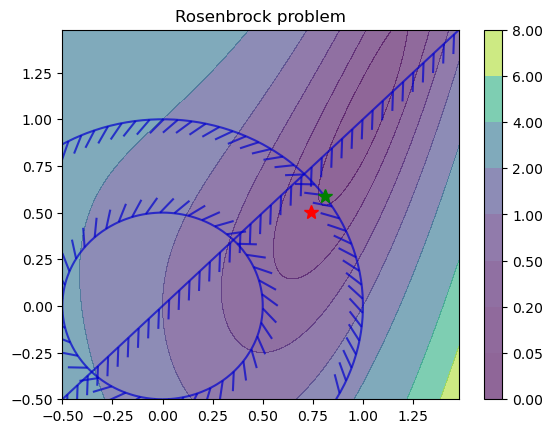

In [16]:
"""
Plots
"""
x1 = np.arange(-0.5, 1.5, 0.02)
y1 = np.arange(-0.5, 1.5, 0.02)
xx, yy = np.meshgrid(x1, y1)

# eval objective and constraints
J = (1 - xx) ** 2 + a * (yy - xx ** 2) ** 2
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

fig, ax = plt.subplots(1, 1)
cp = ax.contourf(xx, yy, J,
                 levels=[0, 0.05, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0],
                 alpha=0.6)
fig.colorbar(cp)
ax.set_title('Rosenbrock problem')
cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg3.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)

# Solution to mpNLP via Neuromancer
datapoint = {'a': torch.tensor([[a]]), 'p': torch.tensor([[p]]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(x_nm)
print(y_nm)

# plot optimal solutions CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=10)
ax.plot(x_nm, y_nm, 'r*', markersize=10)
plt.show(block=True)

In [17]:
def eval_constraints(x, y, p):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y - x)
    con_2_viol = np.maximum(0, (p/2)**2 - (x**2+y**2))
    con_3_viol = np.maximum(0, x**2+y**2 - p**2)
    con_viol = con_1_viol + con_2_viol + con_3_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y):
    obj_value_mean = np.mean((1 - x) ** 2 + a * (y - x ** 2) ** 2)   
    return obj_value_mean

# select n number of random samples to evaluate
n_samples = 1000
idx = np.random.randint(0, nsim, n_samples)
p_samples = samples_test['p'][idx]
a_samples = samples_test['a'][idx]

In [18]:
# create named dictionary for neuromancer
datapoint = {'a': a_samples, 'p': p_samples, 'name': 'test'}

# Solve via neuromancer
t = time.time()
model_out = problem(datapoint)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

In [19]:
# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, n_samples):
    prob, x, y = NLP_param(p_samples[i].numpy(), a_samples[i].numpy(), opti_silent=True)
    sol = prob.solve()
    x_solver.append(sol.value(x))
    y_solver.append(sol.value(y))
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

In [20]:
# Evaluate neuromancer solution
print(f'Solution for {n_samples} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}\n')

# Evaluate solver solution
print(f'Solution for {n_samples} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

Solution for 1000 problems via Neuromancer obtained in 0.0040 seconds
Neuromancer mean constraints violation 0.3294
Neuromancer mean objective value 0.0712

Solution for 1000 problems via solver obtained in 7.2744 seconds
Solver mean constraints violation 0.0851
Solver mean objective value 0.1988

Solution speedup factor 1822.4159
MSE primal optimizers: 0.6094189754585598
mean objective value discrepancy: 64.18 %
